In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


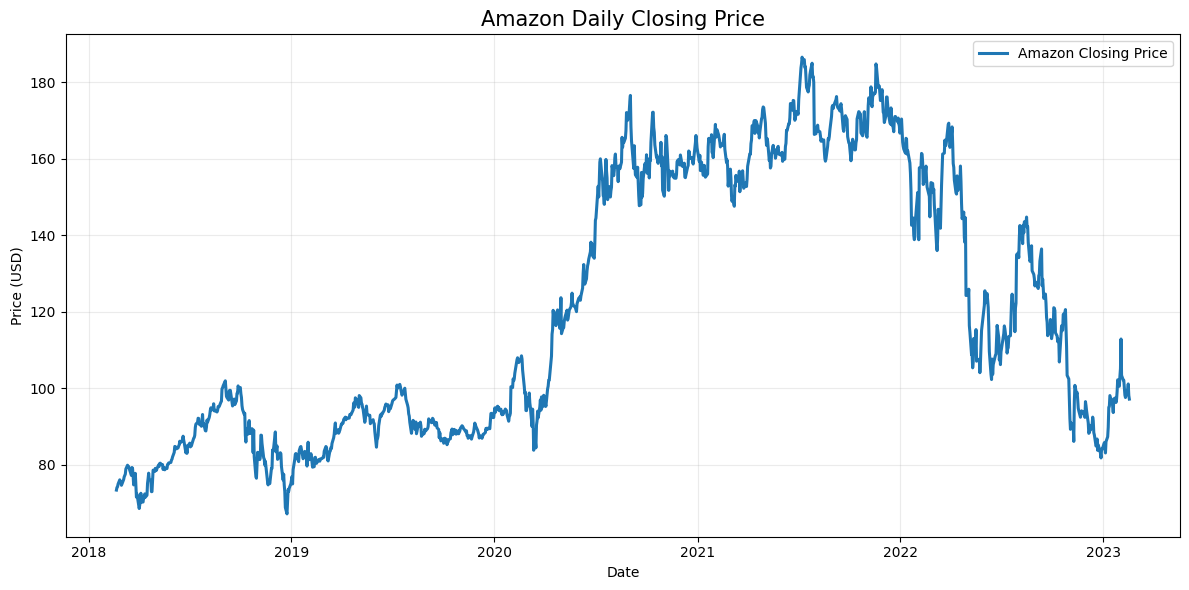

ADF p-value: 0.45297105465166737
KPSS p-value: 0.01
ADF (Differenced) p-value: 0.0
KPSS (Differenced) p-value: 0.1


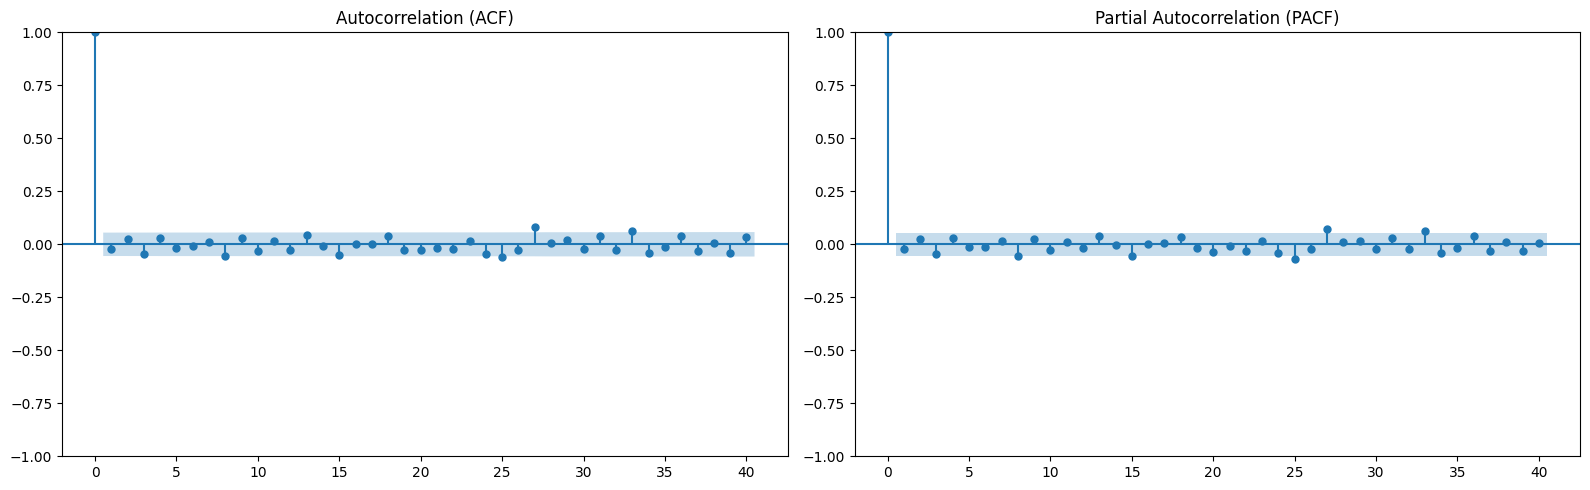

Best ARIMA Order (p,d,q): (2, 1, 2)

📊 Forecast Evaluation (Last 24 Days):
MAE  : 2.93
RMSE : 4.22
MAPE : 2.85%


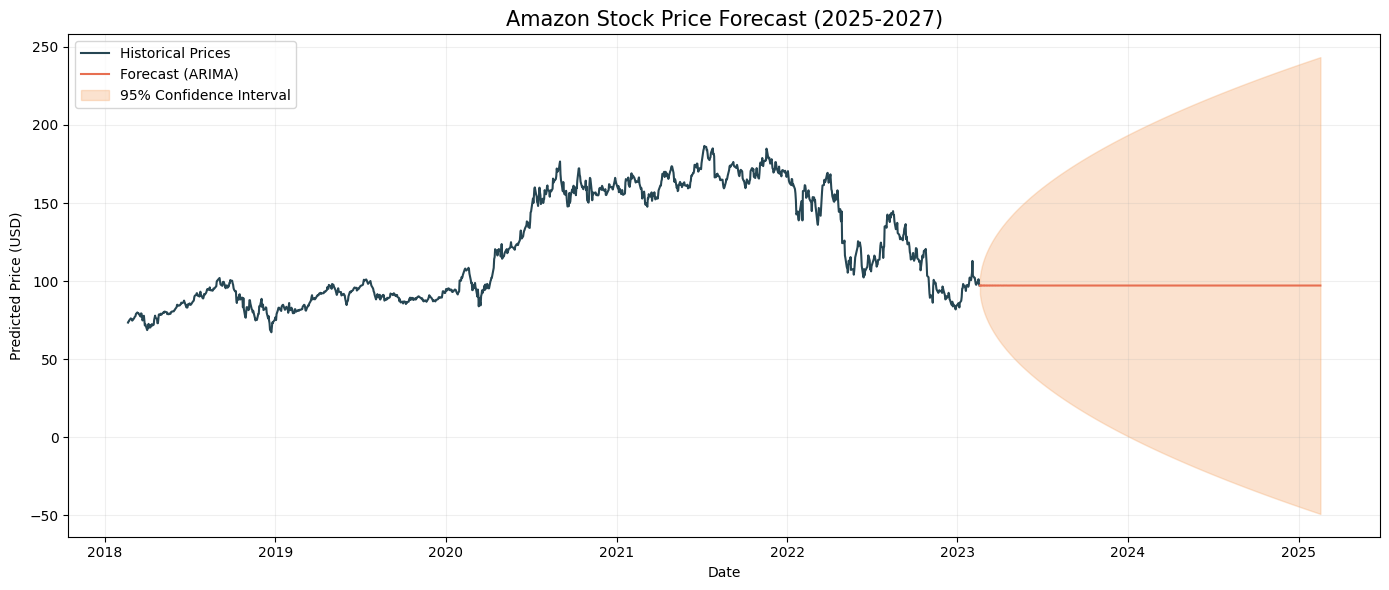

In [7]:
# =====================================
#  Time Series Forecasting Setup
# =====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")


# ============================================
# 1. Load & Visualize Amazon Stock Time Series
# ============================================
amazon_data = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /AMZN.csv")
amazon_data['Date'] = pd.to_datetime(amazon_data['Date'])
amazon_data.set_index('Date', inplace=True)

closing_prices = amazon_data[['Close']]

# Plotting original closing prices
plt.figure(figsize=(12, 6))
plt.plot(closing_prices, color='#1f77b4', linewidth=2.2, label='Amazon Closing Price')
plt.title('Amazon Daily Closing Price', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


# =========================================
# 2. Stationarity Check: ADF and KPSS Tests
# =========================================
adf_pval = adfuller(closing_prices['Close'])[1]
kpss_pval = kpss(closing_prices['Close'], regression='c', nlags='auto')[1]
print("ADF p-value:", adf_pval)
print("KPSS p-value:", kpss_pval)


# =================================================
# 3. Apply First-Order Differencing for Stationarity
# =================================================
closing_diff = closing_prices.diff().dropna()

# Check stationarity again after differencing
adf_diff_pval = adfuller(closing_diff['Close'])[1]
kpss_diff_pval = kpss(closing_diff['Close'], regression='c', nlags='auto')[1]
print("ADF (Differenced) p-value:", adf_diff_pval)
print("KPSS (Differenced) p-value:", kpss_diff_pval)


# ===============================================
# 4. Plot ACF & PACF to Determine ARIMA Parameters
# ===============================================
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(closing_diff, lags=40, ax=ax[0])
ax[0].set_title("Autocorrelation (ACF)")
plot_pacf(closing_diff, lags=40, ax=ax[1])
ax[1].set_title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()


# ======================================================
# 5. Grid Search for Best ARIMA(p, d, q) Configuration
# ======================================================
lowest_aic = float("inf")
optimal_order = None
optimal_arima_model = None

for p in range(4):
    for q in range(4):
        try:
            candidate_model = ARIMA(closing_prices['Close'], order=(p, 1, q)).fit()
            if candidate_model.aic < lowest_aic:
                lowest_aic = candidate_model.aic
                optimal_order = (p, 1, q)
                optimal_arima_model = candidate_model
        except:
            continue

print("Best ARIMA Order (p,d,q):", optimal_order)


# ===================================================
# 6. Forecast the Next 730 Days (Approx. 2 Years)
# ===================================================
forecast_output = optimal_arima_model.get_forecast(steps=730)
forecast_values = forecast_output.predicted_mean
forecast_ci = forecast_output.conf_int()

last_available_date = closing_prices.index[-1]
future_dates = pd.date_range(start=last_available_date + pd.Timedelta(days=1), periods=730, freq='D')


# ================================================================
# 7. Evaluate Forecasting Accuracy via Backtesting (Last 24 Days)
# ================================================================
backtest_days = 24
train_data = closing_prices[:-backtest_days]
test_data = closing_prices[-backtest_days:]

arima_train_model = ARIMA(train_data['Close'], order=optimal_order).fit()
arima_test_forecast = arima_train_model.get_forecast(steps=backtest_days)
predicted_vals = arima_test_forecast.predicted_mean


# ================================================
# 8. Forecast Evaluation Metrics for Backtesting
# ================================================
actual = test_data['Close'].values
predicted = predicted_vals.values

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))
mape = mean_absolute_percentage_error(actual, predicted)

print("\n📊 Forecast Evaluation (Last 24 Days):")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape * 100:.2f}%")


# ===========================================================
# 9. Plot Forecast (2-Year Horizon) with Confidence Bounds
# ===========================================================
plt.figure(figsize=(14, 6))
plt.plot(closing_prices.index, closing_prices['Close'], label='Historical Prices', color='#264653')
plt.plot(future_dates, forecast_values, label='Forecast (ARIMA)', color='#e76f51')
plt.fill_between(future_dates,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='#f4a261', alpha=0.3, label='95% Confidence Interval')
plt.title('Amazon Stock Price Forecast (2025-2027)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Predicted Price (USD)')
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


**RNN Model**

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.2032 - val_loss: 0.0058
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0

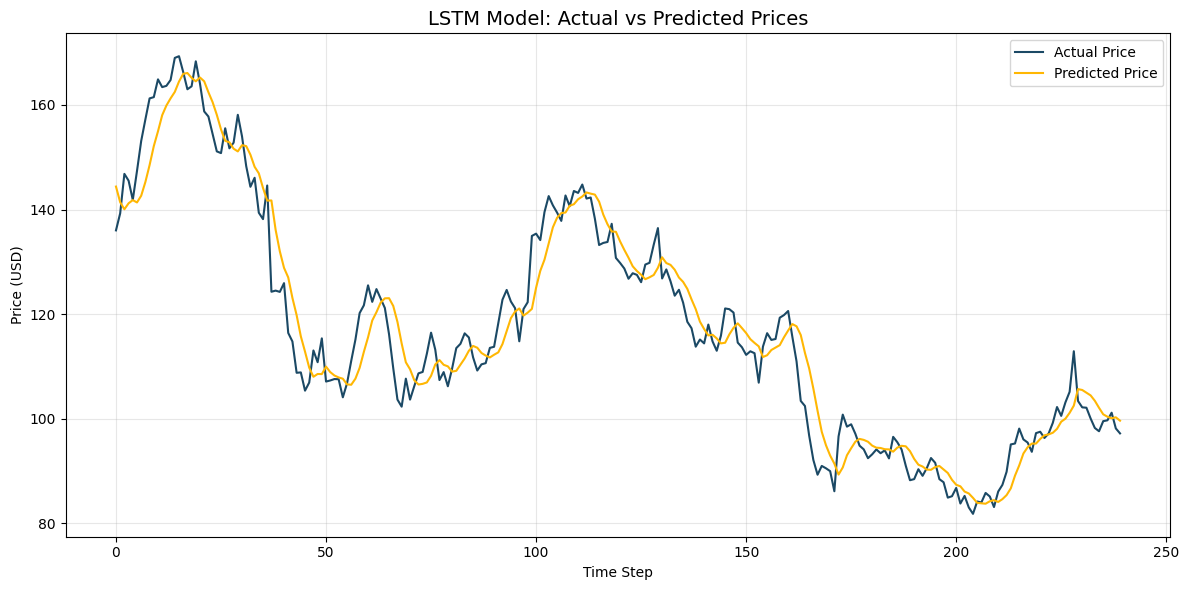

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

📊 LSTM Performance Metrics:
MAE  : 4.2348
RMSE : 5.3702
MAPE : 0.0365


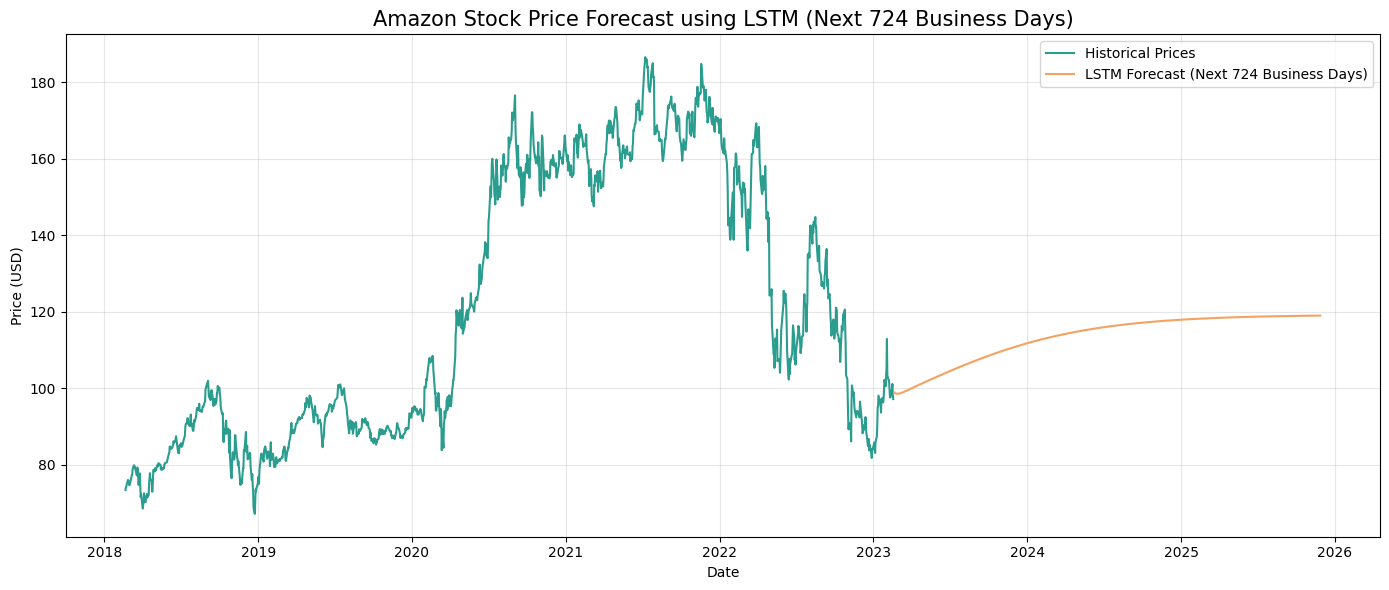

In [8]:
# =====================================
# 2. Load and Normalize Stock Data
# =====================================
df_amzn = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /AMZN.csv")
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])
df_amzn.set_index('Date', inplace=True)
price_data = df_amzn[['Close']].copy()

# Normalize prices
scaler = MinMaxScaler()
price_data['Close'] = scaler.fit_transform(price_data[['Close']])


# =====================================
# 3. Create Sequences for LSTM Input
# =====================================
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_len = 60
X, y = create_sequences(price_data['Close'].values, sequence_len)
X = X.reshape((X.shape[0], X.shape[1], 1))


# =====================================
# 4. Train-Test Split (80/20)
# =====================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


# =====================================
# 5. Build and Train LSTM Model
# =====================================
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


# =====================================
# 6. Plot LSTM Predictions vs Actual
# =====================================
def plot_lstm_predictions(model, X_val, y_val, title="LSTM"):
    predictions = model.predict(X_val)
    true_vals = scaler.inverse_transform(y_val.reshape(-1, 1))
    pred_vals = scaler.inverse_transform(predictions)

    plt.figure(figsize=(12, 6))
    plt.plot(true_vals, label='Actual Price', color='#1b4965')
    plt.plot(pred_vals, label='Predicted Price', color='#ffb703')
    plt.title(f'{title} Model: Actual vs Predicted Prices', fontsize=14)
    plt.xlabel('Time Step')
    plt.ylabel('Price (USD)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return true_vals, pred_vals

plot_lstm_predictions(lstm_model, X_test, y_test)


# =====================================
# 7. Evaluate LSTM Forecast Accuracy
# =====================================
lstm_preds_scaled = lstm_model.predict(X_test)
true_vals = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_vals = scaler.inverse_transform(lstm_preds_scaled).flatten()

mae = mean_absolute_error(true_vals, predicted_vals)
rmse = np.sqrt(mean_squared_error(true_vals, predicted_vals))
mape = mean_absolute_percentage_error(true_vals, predicted_vals)

print("\n📊 LSTM Performance Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}")


# =====================================
# 8. Forecast Next 724 Business Days
# =====================================
def forecast_lstm_future(model, recent_data, forecast_days=724, seq_len=60):
    last_seq = recent_data[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(forecast_days):
        next_val = model.predict(last_seq, verbose=0)[0][0]
        forecast.append(next_val)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_val]]], axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

future_prices_lstm = forecast_lstm_future(
    lstm_model, price_data['Close'].values, forecast_days=724, seq_len=sequence_len
)


# =====================================
# 9. Plot Historical + Future Forecast
# =====================================
forecast_dates = pd.date_range(
    start=price_data.index[-1] + pd.DateOffset(days=1),
    periods=724,
    freq='B'
)

plt.figure(figsize=(14, 6))
plt.plot(
    price_data.index,
    scaler.inverse_transform(price_data['Close'].values.reshape(-1, 1)),
    label='Historical Prices',
    color='#2a9d8f'
)
plt.plot(
    forecast_dates,
    future_prices_lstm,
    label='LSTM Forecast (Next 724 Business Days)',
    color='#f4a261'
)
plt.title('Amazon Stock Price Forecast using LSTM (Next 724 Business Days)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.1725 - val_loss: 0.0056
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0064 - val_loss: 0.0021
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 6.9307e-04 - val_loss: 0.0018
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 6.7269e-04 - val_loss: 0.0018
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 6.8900e-04 - val_loss: 0.0017
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.7182e-04 - val_loss: 0.0018
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 7.2543e-04 - val_loss: 0.0016
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.1542e-04 - val_loss: 0.0016
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 6.2857e-04 - val_loss: 0.0015
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 5.5580e-04 - val_loss: 0.0016
Epoch 12/50
30/30 ━━━━━━━━━━━━━

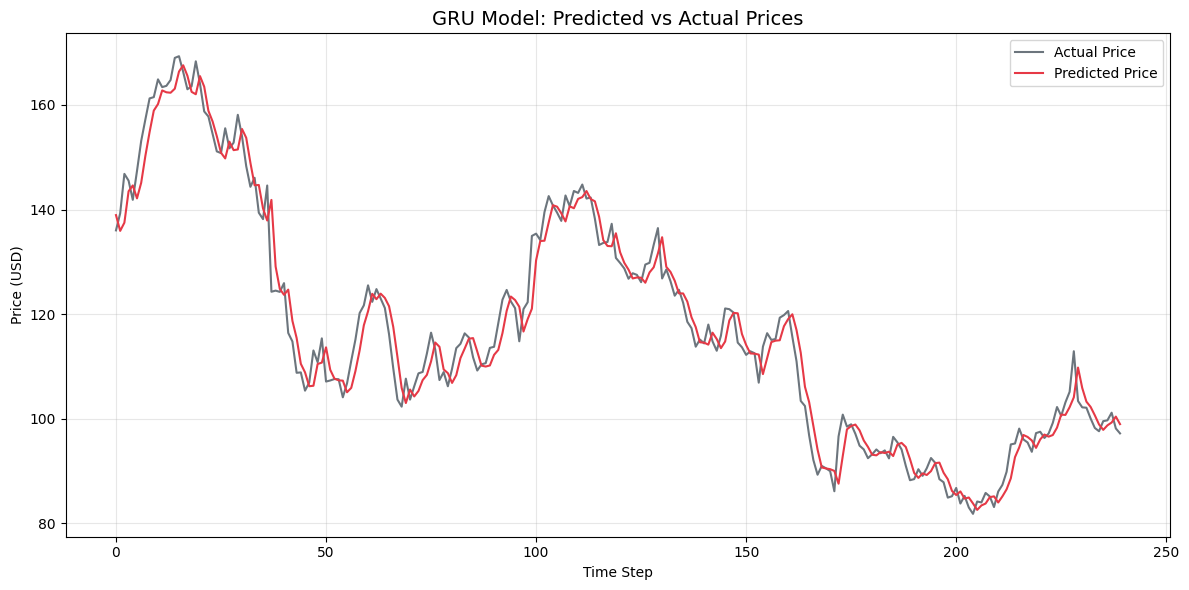

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

 GRU Model Evaluation Metrics:
MAE  : 3.0041
RMSE : 3.9057
MAPE : 0.0258


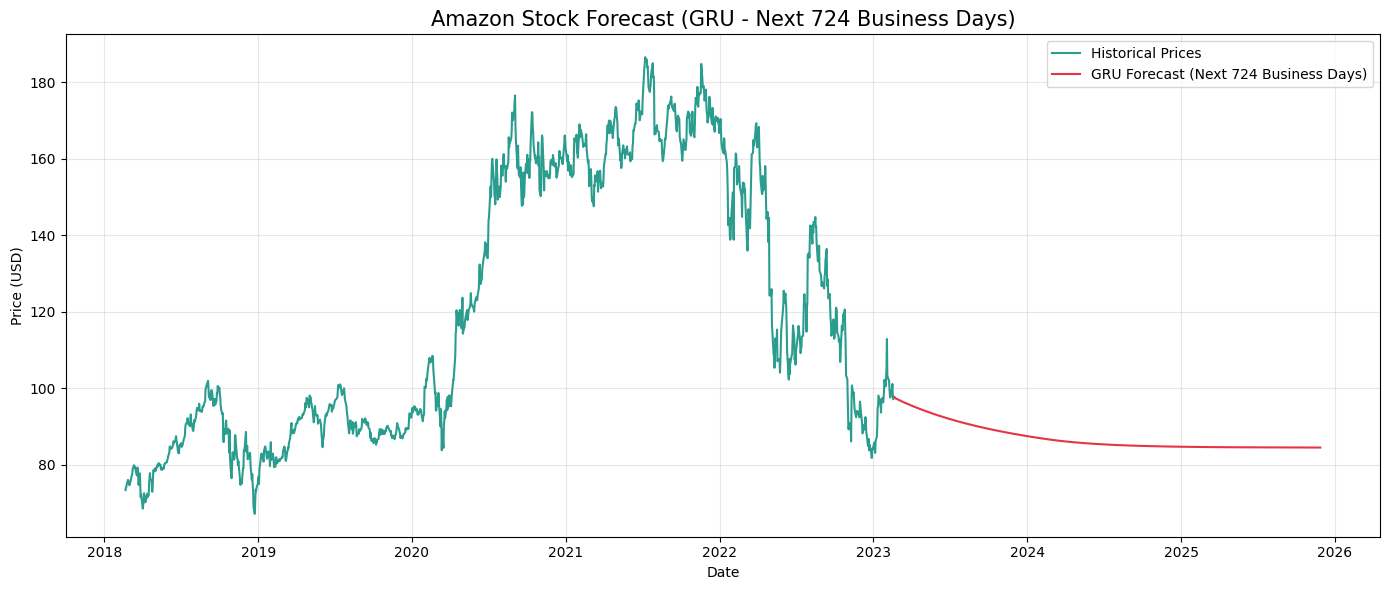

In [9]:
# 2. Load and Normalize Amazon Stock Data
df_amzn = pd.read_csv("/content/drive/MyDrive/ML Work/Assignment /AMZN.csv")
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])
df_amzn.set_index('Date', inplace=True)

price_data = df_amzn[['Close']].copy()

scaler = MinMaxScaler()
price_data['Close'] = scaler.fit_transform(price_data[['Close']])


# 3. Create Sequences for GRU Forecasting
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

sequence_len = 60
X, y = create_sequences(price_data['Close'].values, sequence_len)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 4. Train/Test Data Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


# 5. Define and Train GRU Model

gru_model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


# 6. Visualize Predictions vs Actual
def plot_predictions(model, X_test, y_test, label="GRU"):
    preds = model.predict(X_test)
    true_vals = scaler.inverse_transform(y_test.reshape(-1, 1))
    pred_vals = scaler.inverse_transform(preds)

    plt.figure(figsize=(12, 6))
    plt.plot(true_vals, label='Actual Price', color='#6c757d')        # Slate Gray
    plt.plot(pred_vals, label='Predicted Price', color='#e63946')     # Crimson Red
    plt.title(f'{label} Model: Predicted vs Actual Prices', fontsize=14)
    plt.xlabel('Time Step')
    plt.ylabel('Price (USD)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return true_vals, pred_vals

plot_predictions(gru_model, X_test, y_test, label="GRU")


# 7. Evaluate GRU Forecast Accuracy
scaled_preds = gru_model.predict(X_test)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_prices = scaler.inverse_transform(scaled_preds).flatten()

mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

print("\n GRU Model Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}")


# 8. Forecast Next 724 Business Days
def forecast_future(model, recent_data, forecast_days=724, seq_len=60):
    last_seq = recent_data[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(forecast_days):
        next_val = model.predict(last_seq, verbose=0)[0][0]
        forecast.append(next_val)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_val]]], axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

forecast_days = 724
future_forecast = forecast_future(gru_model, price_data['Close'].values, forecast_days, sequence_len)


# 9. Plot Historical + Forecasted Prices

forecast_dates = pd.date_range(
    start=price_data.index[-1] + pd.DateOffset(days=1),
    periods=forecast_days,
    freq='B'
)

plt.figure(figsize=(14, 6))
plt.plot(price_data.index, scaler.inverse_transform(price_data['Close'].values.reshape(-1, 1)),
         label='Historical Prices', color='#2a9d8f')                   # Sea Green
plt.plot(forecast_dates, future_forecast,
         label='GRU Forecast (Next 724 Business Days)', color='#e63446')  # Crimson Red
plt.title('Amazon Stock Forecast (GRU - Next 724 Business Days)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
